In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split
import h5py
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.cuda.amp as amp 
import random
from tqdm.autonotebook import tqdm
import skimage.metrics
import lpips

/tmp/ipykernel_1511100/172947824.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def positional_encoding(x, L=10):
    encodings = [x]
    for i in range(L):
        encodings.append(torch.sin(2.0 ** i * np.pi * x))
        encodings.append(torch.cos(2.0 ** i * np.pi * x))
    return torch.cat(encodings, dim=-1)

In [3]:
class INR_FFN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=256, output_dim=3, num_layers=5, L=10):
        super(INR_FFN, self).__init__()
        self.L = L
        layers = []
        in_dim = input_dim * (2 * L + 1)
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            in_dim = hidden_dim
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = positional_encoding(x, self.L)  
        return self.network(x)

In [4]:
def load_hdf5_data(h5_file):
    with h5py.File(h5_file, 'r') as f:
        data = f['X_jets'][:] 
    return data

h5_file = 'quark-gluon_data-set_n139306.hdf5'
images = load_hdf5_data(h5_file)

print(f"Data Shape: {images.shape}") 
print(f"Min: {images.min()}, Max: {images.max()}")
print(f"First Image - Min: {images[0].min()}, Max: {images[0].max()}")

mean_val = images.mean()
std_val = images.std()
print(f"Mean: {mean_val}, Std: {std_val}") 

Data Shape: (139306, 125, 125, 3)
Min: 0.0, Max: 756.5962524414062
First Image - Min: 0.0, Max: 0.2492586076259613
Mean: 5.392230013967492e-05, Std: 0.011045179329812527


In [5]:
class INRDataset(Dataset):
    def __init__(self, image, mean=0.0, std=1.0):
        self.image = (image - mean) / std  
        self.H, self.W, self.C = self.image.shape  

        xs = np.linspace(0, 1, self.W)  
        ys = np.linspace(0, 1, self.H)  
        self.coords = np.stack(np.meshgrid(xs, ys), axis=-1).reshape(-1, 2)  

    def __len__(self):
        return 1 

    def __getitem__(self, idx):
        coords = torch.FloatTensor(self.coords)  
        pixels = torch.FloatTensor(self.image.reshape(-1, self.C))  
        return coords, pixels

Training on image 2863
Epoch 1000/10000, Train Loss: 0.000034
Epoch 2000/10000, Train Loss: 0.000004
Epoch 3000/10000, Train Loss: 0.000002
Epoch 4000/10000, Train Loss: 0.000001
Epoch 5000/10000, Train Loss: 0.000001
Epoch 6000/10000, Train Loss: 0.000002
Epoch 7000/10000, Train Loss: 0.000002
Epoch 8000/10000, Train Loss: 0.000002
Epoch 9000/10000, Train Loss: 0.000001
Epoch 10000/10000, Train Loss: 0.000000
Training on image 77489
Epoch 1000/10000, Train Loss: 0.000032
Epoch 2000/10000, Train Loss: 0.000010
Epoch 3000/10000, Train Loss: 0.000007
Epoch 4000/10000, Train Loss: 0.000006
Epoch 5000/10000, Train Loss: 0.000006
Epoch 6000/10000, Train Loss: 0.000006
Epoch 7000/10000, Train Loss: 0.000009
Epoch 8000/10000, Train Loss: 0.000001
Epoch 9000/10000, Train Loss: 0.000001
Epoch 10000/10000, Train Loss: 0.000000
Training on image 121445
Epoch 1000/10000, Train Loss: 0.000018
Epoch 2000/10000, Train Loss: 0.000016
Epoch 3000/10000, Train Loss: 0.000011
Epoch 4000/10000, Train Loss:

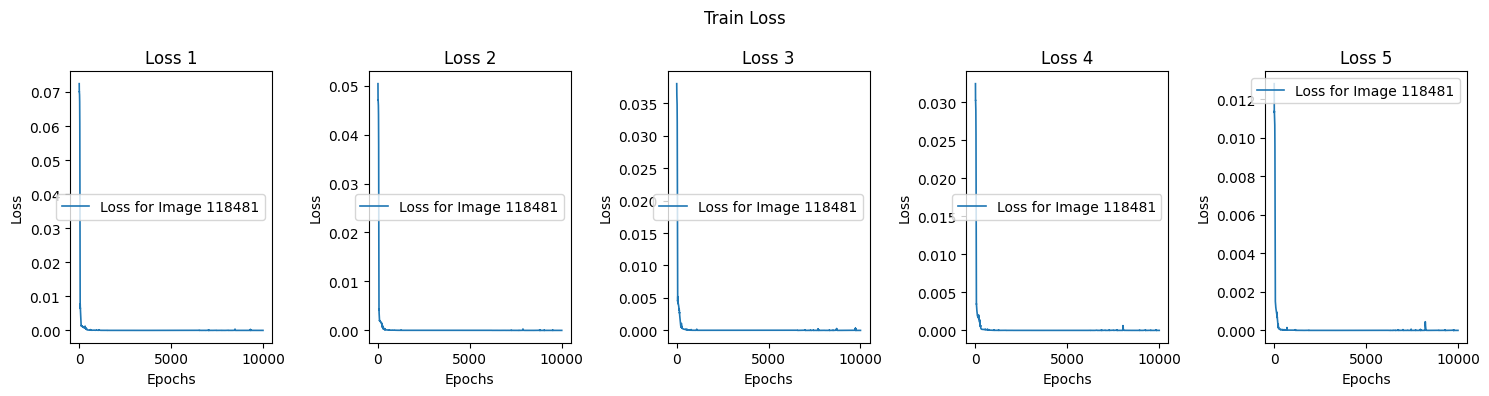

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6643083e-05..0.60190964].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.872937e-05..0.47018144].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.6434627e-05..0.3856114].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.375978e-05..0.31647608].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.3903943e-05..0.13351153].


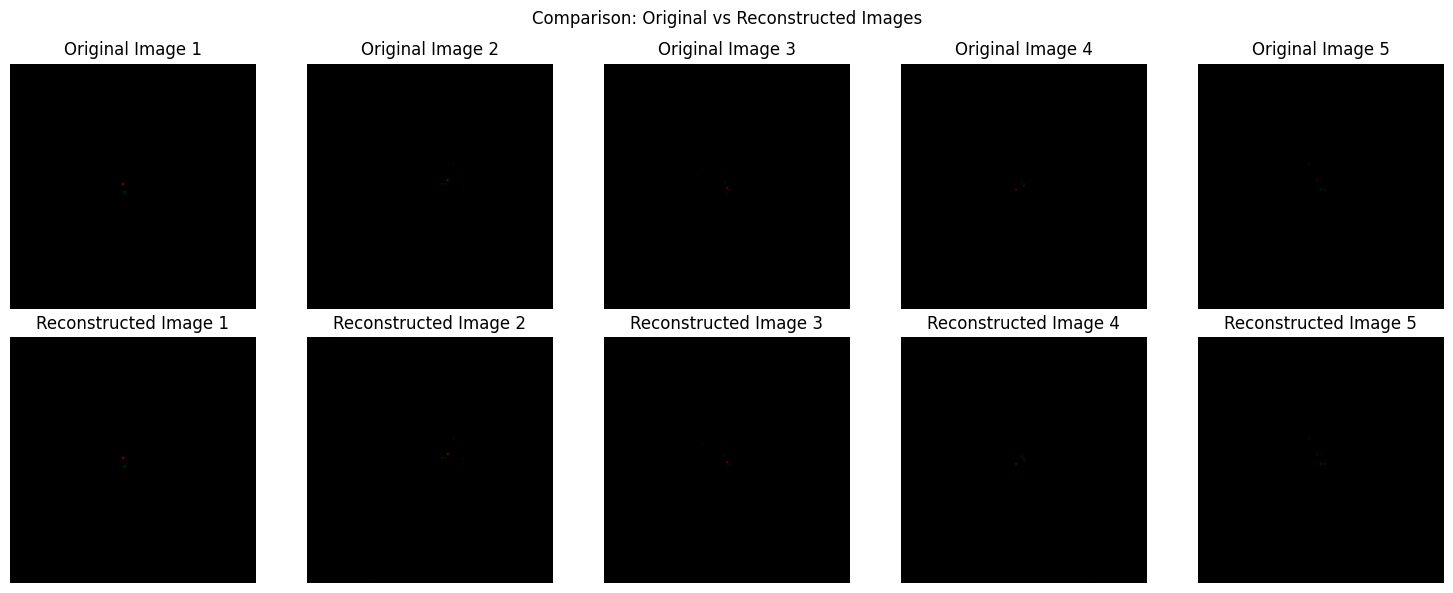

In [6]:
num_samples = 5
random_indices = random.sample(range(len(images)), num_samples)  
all_train_losses = []
all_original_images = []
all_reconstructed_images = []

def denormalize(image, mean, std):
    return image * std + mean

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for idx, image_idx in enumerate(random_indices):
    print(f"Training on image {image_idx+1}")

    dataset = INRDataset(images[image_idx], mean=mean_val, std=std_val)
    train_loader = DataLoader(dataset, batch_size=1, shuffle=False, pin_memory=True)

    model = INR_FFN().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=1e-6)

    num_epochs = 10000
    train_losses = []
    scaler = amp.GradScaler()

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for coords, pixels in train_loader:
            coords, pixels = coords.to(device), pixels.to(device)
            optimizer.zero_grad()

            with amp.autocast(): 
                outputs = model(coords) 
                loss = criterion(outputs, pixels)

            scaler.scale(loss).backward()  
            scaler.step(optimizer) 
            scaler.update() 
            total_train_loss += loss.item()

        train_loss = total_train_loss / len(train_loader)
        train_losses.append(train_loss)

        scheduler.step()

        if (epoch + 1) % 1000 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}")

    all_train_losses.append(train_losses)

    model.eval()
    H, W, C = images[image_idx].shape

    full_coords = np.stack(np.meshgrid(np.linspace(0, 1, W), np.linspace(0, 1, H)), axis=-1).reshape(-1, 2)
    full_coords = torch.FloatTensor(full_coords).to(device)

    with torch.no_grad():
        reconstructions = model(full_coords).cpu().numpy()

    reconstructed_image = reconstructions.reshape(H, W, C)

    reconstructed_image = denormalize(reconstructions.reshape(H, W, C), mean_val, std_val)

    all_original_images.append(images[image_idx])
    all_reconstructed_images.append(reconstructed_image)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))

for i in range(num_samples):
    axes[i].plot(range(1, num_epochs+1), all_train_losses[i], label=f'Loss for Image {image_idx+1}', linewidth=1.2)
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel("Loss")
    axes[i].legend()
    axes[i].set_title(f"Loss {i+1}")

plt.suptitle("Train Loss")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

for i in range(num_samples):
    axes[0, i].imshow(all_original_images[i])
    axes[0, i].set_title(f"Original Image {i+1}")
    axes[0, i].axis("off")

    axes[1, i].imshow(all_reconstructed_images[i])
    axes[1, i].set_title(f"Reconstructed Image {i+1}")
    axes[1, i].axis("off")

plt.suptitle("Comparison: Original vs Reconstructed Images")
plt.tight_layout()
plt.show()

In [7]:
loss_fn = lpips.LPIPS(net='alex')

def calculate_psnr(original, reconstructed, max_val=1.0):
    mse = torch.mean((original - reconstructed) ** 2)
    psnr = 10 * torch.log10(max_val**2 / mse)
    return psnr.item()

def calculate_ssim(original, reconstructed):
    original_np = original.numpy()
    reconstructed_np = reconstructed.numpy()
    min_dim = min(original_np.shape[:2]) 
    win_size = min(7, min_dim)  

    if min_dim < 7:
        print(f"Warning: Image size too small for SSIM (size: {original_np.shape[:2]}), skipping SSIM calculation.")
        return 1.0 

    ssim = skimage.metrics.structural_similarity(original_np, reconstructed_np, 
                                                 channel_axis=-1, data_range=1.0, win_size=win_size)
    return ssim

def calculate_lpips(original, reconstructed):
    transform = transforms.ToTensor()
    
    original_torch = transform(original).unsqueeze(0) 
    reconstructed_torch = transform(reconstructed).unsqueeze(0)
    
    lpips_value = loss_fn(original_torch, reconstructed_torch)
    return lpips_value.item()

psnr_scores = []
ssim_scores = []
lpips_scores = []

for i in range(num_samples):
    original = torch.tensor(all_original_images[i])
    reconstructed = torch.tensor(all_reconstructed_images[i])
    denormalized_reconstructed_image = denormalize(reconstructed_image, mean_val, std_val)

    psnr_scores.append(calculate_psnr(torch.tensor(all_original_images[i]), torch.tensor(denormalized_reconstructed_image)))
    ssim_scores.append(calculate_ssim(torch.tensor(all_original_images[i]), torch.tensor(denormalized_reconstructed_image)))
    lpips_scores.append(calculate_lpips(all_original_images[i], denormalized_reconstructed_image))

for i in range(num_samples):
    print(f"Image {i+1}:")
    print(f"  PSNR: {psnr_scores[i]:.2f} dB")
    print(f"  SSIM: {ssim_scores[i]:.4f}")
    print(f"  LPIPS: {lpips_scores[i]:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/beegfs/home/anning/.conda/envs/qenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/beegfs/home/anning/.conda/envs/qenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /beegfs/home/anning/.conda/envs/qenv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Image 1:
  PSNR: 50.68 dB
  SSIM: 0.9979
  LPIPS: 0.0902
Image 2:
  PSNR: 52.41 dB
  SSIM: 0.9976
  LPIPS: 0.0552
Image 3:
  PSNR: 53.54 dB
  SSIM: 0.9976
  LPIPS: 0.0350
Image 4:
  PSNR: 54.32 dB
  SSIM: 0.9972
  LPIPS: 0.0341
Image 5:
  PSNR: 58.69 dB
  SSIM: 0.9983
  LPIPS: 0.0073
